## Instalação e importação dos pacotes

In [1]:
# In[0.2]: Importação dos pacotes necessários

import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
import statsmodels.api as sm # estimação de modelos
from pymer4.models import Lmer # estimação de modelos HLM3 neste código
from scipy import stats # estatística chi2
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from scipy.stats import gaussian_kde # inserção de KDEs em gráficos
from matplotlib.gridspec import GridSpec # plotagem de gráficos separados
import time # definição do intervalo de tempo entre gráficos com animação
import imageio # para geração de figura GIF
from tqdm import tqdm # adiciona um indicador de progresso do código

# Supervised Machine Learning - Modelagem Multinível

## O Conceito

Os Modelos Multinível, também conhecidos como: 

- Modelos Multinível;
- Modelos Hierárquicos (HLM - Herarchical Linear Models)
- Modelos Mistos (Mixed Models)
- GLLAMM (Generalized Linear and Latent Multilevel Models)
- Nested Models (Modelos Aninhados)
- Modelos Contextuais
- RCM (Random Coefficient Models)
- GLMM

São modelos que reconhecem a existência de estrutura multinível ou hierárquica nos dados. Um exemplo seria um estudo sobre alunos. Poderíamos definir 3 níveis:

1. Dados dos alunos como: Horas semanais de estudo, renda familiar e endereço (É algo que varia individualmente para cada aluno)
2. Tipo de escola: Pública ou Privada (Algo que incide sobre todos os alunos)
3. Estado, cidade, diretoria de ensino (Algo que afeta várias de acordo com sua localização)

Ao contrário dos modelos GLM, os modelos GLLMM geram vários ajustes diferentes em cima da mesma base de dados.

\begin{align}
\text{Escola 1:} \qquad Y_{i1} = \beta_{01} + \beta_{11}.X_{i1} + \epsilon_{i1}\\
\text{Escola 2:} \qquad Y_{i2} = \beta_{02} + \beta_{12}.X_{i2} + \epsilon_{i2}\\
\text{Escola n:} \qquad Y_{in} = \beta_{0n} + \beta_{1n}.X_{in} + \epsilon_{in}\\
\end{align}

Por conta disso, teremos um modelo para o intercepto $\alpha$ e um modelo para a inclinação da reta do ajuste.

O Modelo Multinível é dado por:

\begin{equation}
Y_{ij} = \gamma_{00} + \gamma_{10}.X_{ij} + \gamma_{01}.W_j + \gamma_{11}.W_j.X_{ij} + \nu_{0j} + \nu_{1j}.X_{ij} + \epsilon_{ij} 
\end{equation}

Onde

$\gamma_{00} + \gamma_{10}.X_{ij} + \gamma_{01}.W_j + \gamma_{11}.W_j.X_{ij} $ são os Efeitos Fixos.\
$\nu_{0j} + \nu_{1j}.X_{ij} + \epsilon_{ij} $ São os efeitos aleatórios.

Caso a variância dos interceptos $\nu_{0j}$ ou a variância das inclinações $\nu_{1j}$ seja diferente de zero, então temos vários ajustes que dependendem de características das variáveis do banco de dados, e portanto, os modelos tradicionais  de estimação de parâmetros como mínimos quadrados ordinários não serão adequados.

Caso:

- $Var(\nu_{0j} \cong 0) \quad \text{e} \quad Var(\nu_{ij}) \approx 0$ : Usamos o modelo OLS (GLM)
- $Var(\nu_{0j} \neq 0) \quad \text{e} \quad Var(\nu_{ij}) \approx 0$ : Usamos o processo de dummyzação
- $Var(\nu_{0j} \cong 0) \quad \text{e} \quad Var(\nu_{ij}) \neq 0$ : Usamos o Modelo com Inclinações Aleatórias, e todos os ajustes possuem o mesmo intercepto.
- $Var(\nu_{0j} \neq 0) \quad \text{e} \quad Var(\nu_{ij}) \neq 0$ : Usamos o Modelo com Interceptos e Inclinações Aleatórias.

Para entender mais podemos consultar o link http://mfviz.com/hierarchical-models/.

Os modelos multinível permitem o desenvolvimento de novos e mais bem elaborados constructos para predição e tomada de decisão.

## Aplicações

Apesar do seu poder, os modelos multinível são pouco utilizados. Segundo Emmanuel Lazega e Tom Snijders, a razão para isso se dá pelas seguintes razões:

- Estrutura dos dados
- Não consideração de natureza multinível nos dados
- Capacidade computacional por vezes insuficiente, princialmente quando da existência de interações profundas.

## Desafios em Modelagem Multinível

- Interações Profundas e Capacidade de Processamento
- Métodos de Estimação dos Parâmetros
- Clusterização da amostra

Isso tudo leva a uma estimação de um modelo com a melhor aderência possível aos dados da amostra.

Outra questão que está em discussão no momento, é que não há procedimento stepwize para a modelagem multinível. Com isso, a estratégia é testar um *Modelo Nulo*, e verificar a significância estatística do $\nu_{0j}$ e $\nu_{1j}$, caso nenhum dos dois seja estatísticamente significativo, então utilizamos o modelo OLS (MQO). Caso seja estatísticamente significativos, utilizamos o modelo completo.

# Exemplo: `desempenho_aluno_escola.csv`

Estudo de uma base de dados de alunos aninhados em escolas. 

Variáveis:

- `estudante`: ID do estudante
- `escola`: ID da escola
- `desempenho`: Nota do estudante no vestibular
- `horas`: Horas de estudo semanal
- `texp`: tempo de experiência médio dos docentes da escola

## Carregando a base de dados

In [2]:
# Carregamento da base de dados 'desempenho_aluno_escola'
df_aluno_escola = pd.read_csv('desempenho_aluno_escola.csv', delimiter=',')

# Visualização da base de dados 'desempenho_aluno_escola'
df_aluno_escola

,estudante,escola,desempenho,horas,texp
0,1,1,25.0,11,3.6
1,2,1,52.0,23,3.6
2,3,1,52.0,25,3.6
3,4,1,30.0,14,3.6
4,5,1,51.0,24,3.6
...,...,...,...,...,...
353,354,10,46.5,28,3.9
354,355,10,21.0,9,3.9
355,356,10,42.0,27,3.9
356,357,10,14.0,7,3.9


In [3]:
# Atribuição de categorias para as variáveis 'estudante' e 'escola'
df_aluno_escola['estudante'] = df_aluno_escola['estudante'].astype('category')
df_aluno_escola['escola'] = df_aluno_escola['escola'].astype('category')

# Características das variáveis do dataset
df_aluno_escola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   estudante   358 non-null    category
 1   escola      358 non-null    category
 2   desempenho  358 non-null    float64 
 3   horas       358 non-null    int64   
 4   texp        358 non-null    float64 
dtypes: category(2), float64(2), int64(1)
memory usage: 20.8 KB


In [4]:
# Estatísticas univariadas
df_aluno_escola.describe()

,desempenho,horas,texp
count,358.000000,358.000000,358.000000
mean,41.554190,18.997207,5.161173
std,23.225896,6.368910,3.682676
min,6.500000,4.000000,1.900000
25%,21.000000,14.000000,1.900000
50%,35.500000,20.000000,3.600000
75%,59.000000,24.000000,7.500000
max,100.000000,31.000000,13.000000


## Análise do desempenho escolar

<Axes: xlabel='horas', ylabel='desempenho'>

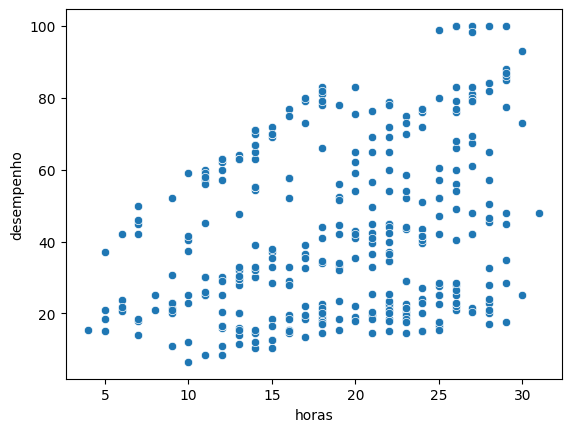

In [5]:
sns.scatterplot(x='horas', y='desempenho', data=df_aluno_escola)

<Axes: xlabel='horas', ylabel='desempenho'>

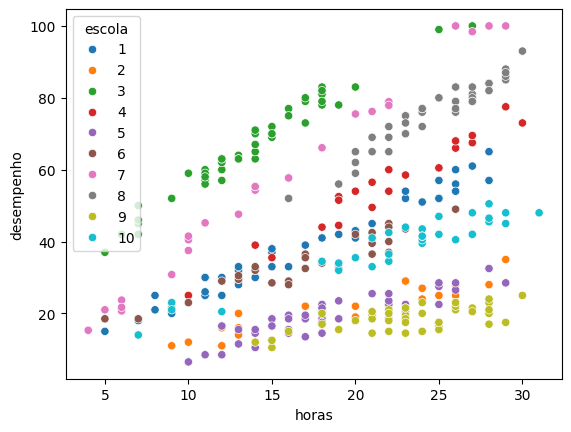

In [6]:
sns.scatterplot(x='horas', y='desempenho', data=df_aluno_escola, hue='escola')

In [7]:
# In[1.1]: Estudo sobre o desbalanceamento dos dados por escola

df_aluno_escola.groupby('escola')['estudante'].count().reset_index()

# In[1.2]: Desempenho médio dos estudantes por escola

desempenho_medio = df_aluno_escola.groupby('escola')['desempenho'].mean().reset_index()
desempenho_medio


C:\Users\Lucas Rezende\AppData\Local\Temp\ipykernel_14132\1811756088.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_aluno_escola.groupby('escola')['estudante'].count().reset_index()
C:\Users\Lucas Rezende\AppData\Local\Temp\ipykernel_14132\1811756088.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desempenho_medio = df_aluno_escola.groupby('escola')['desempenho'].mean().reset_index()


,escola,desempenho
0,1,36.765957
1,2,21.400000
2,3,67.125000
3,4,55.325000
4,5,19.270833
5,6,33.966667
6,7,57.532143
7,8,75.428571
8,9,18.556818
9,10,38.590909


<Axes: xlabel='escola', ylabel='desempenho'>

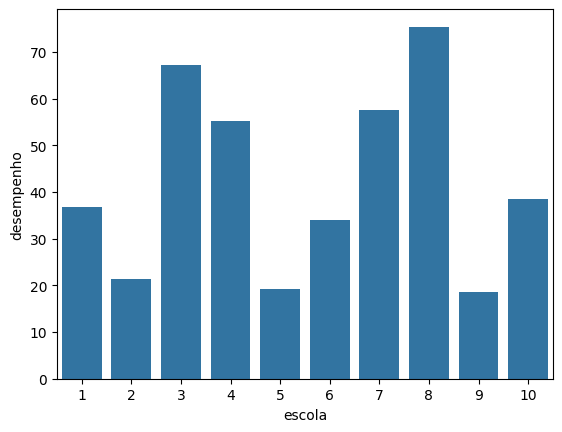

In [8]:
sns.barplot(x=desempenho_medio['escola'], y=desempenho_medio['desempenho'])

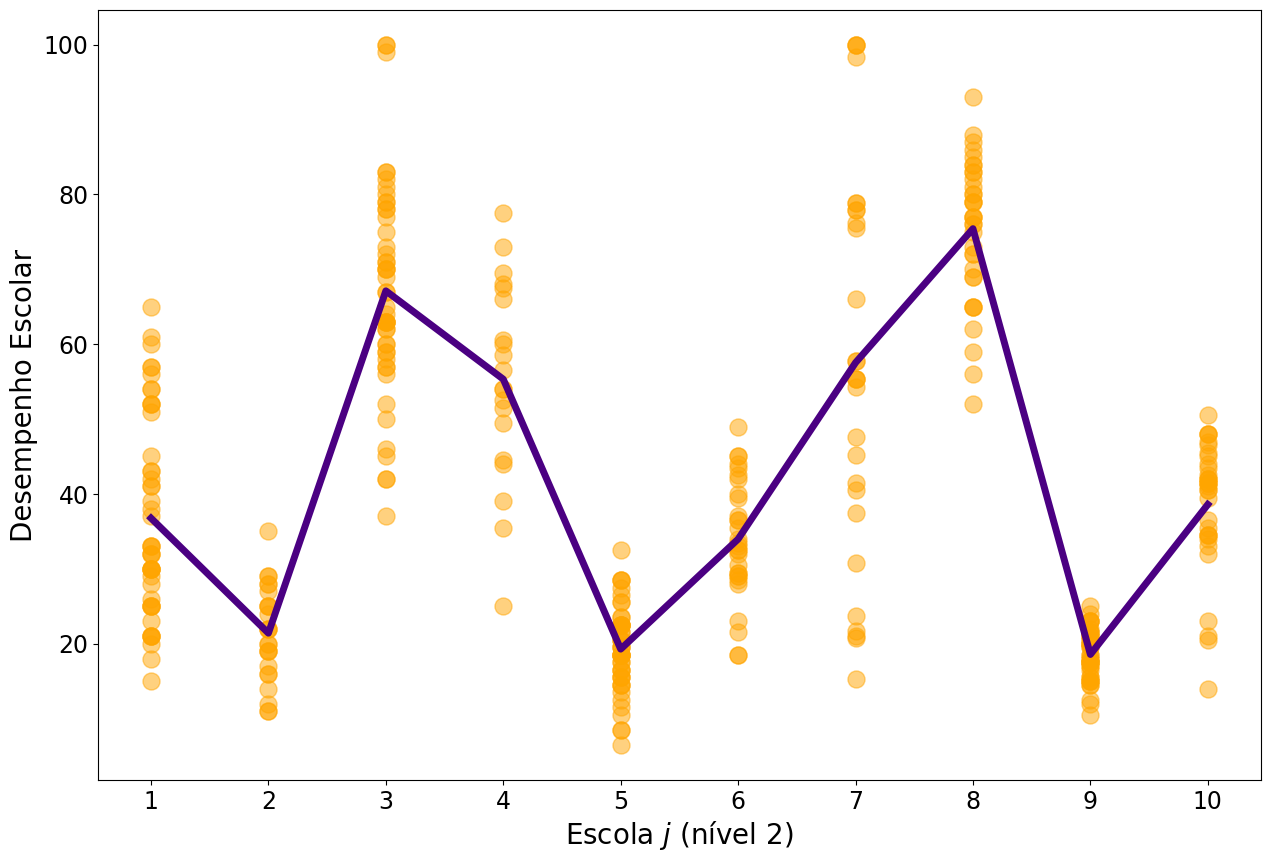

In [9]:
# In[1.3]: Gráfico do desempenho escolar médio dos estudantes por escola

plt.figure(figsize=(15,10))
plt.plot(desempenho_medio['escola'], desempenho_medio['desempenho'],
         linewidth=5, color='indigo')
plt.scatter(df_aluno_escola['escola'], df_aluno_escola['desempenho'],
            alpha=0.5, color='orange', s = 150)
plt.xlabel('Escola $j$ (nível 2)', fontsize=20)
plt.ylabel('Desempenho Escolar', fontsize=20)
plt.xticks(desempenho_medio.escola, fontsize=17)
plt.yticks(fontsize=17)
plt.show()

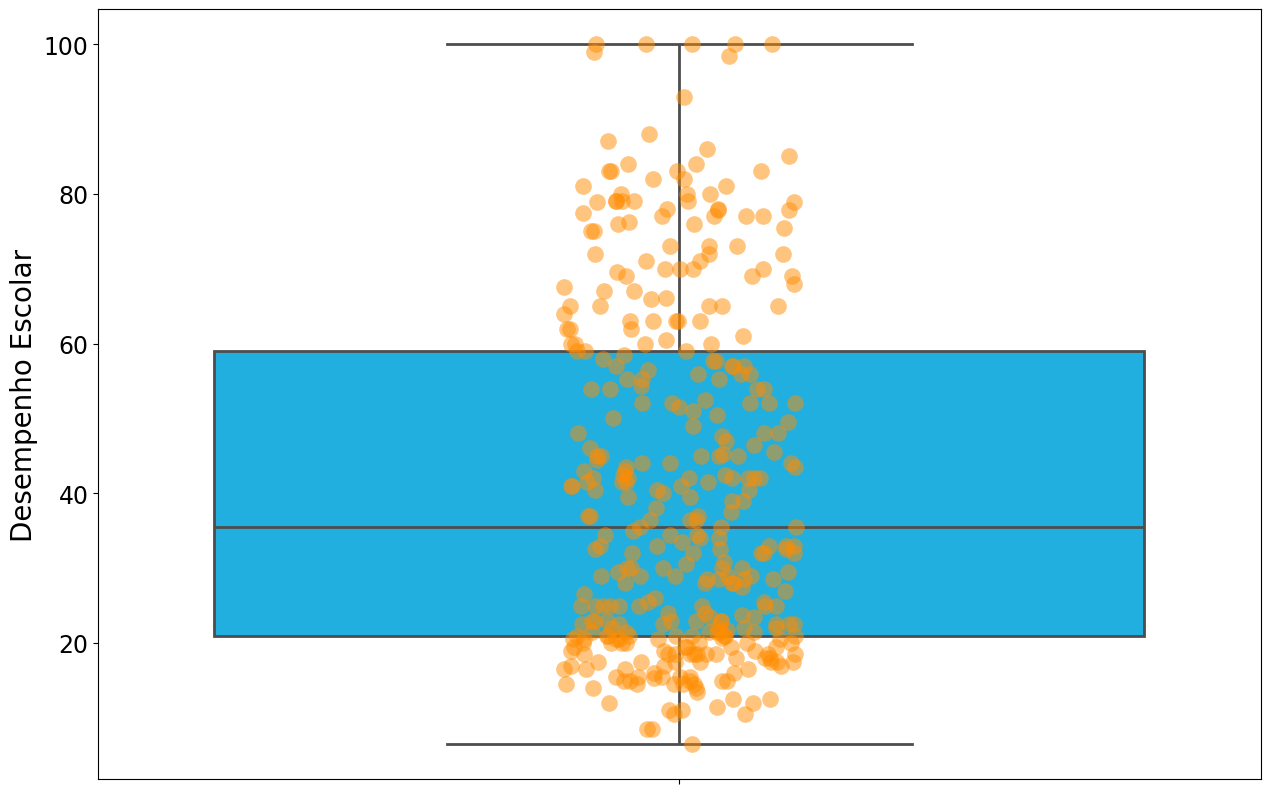

In [10]:
# In[1.4]: Boxplot da variável dependente ('desempenho')

plt.figure(figsize=(15,10))
sns.boxplot(data=df_aluno_escola, y='desempenho',
            linewidth=2, orient='v', color='deepskyblue')
sns.stripplot(data=df_aluno_escola, y='desempenho',
              color='darkorange', jitter=0.1, size=12, alpha=0.5)
plt.ylabel('Desempenho Escolar', fontsize=20)
plt.yticks(fontsize=17)
plt.show()

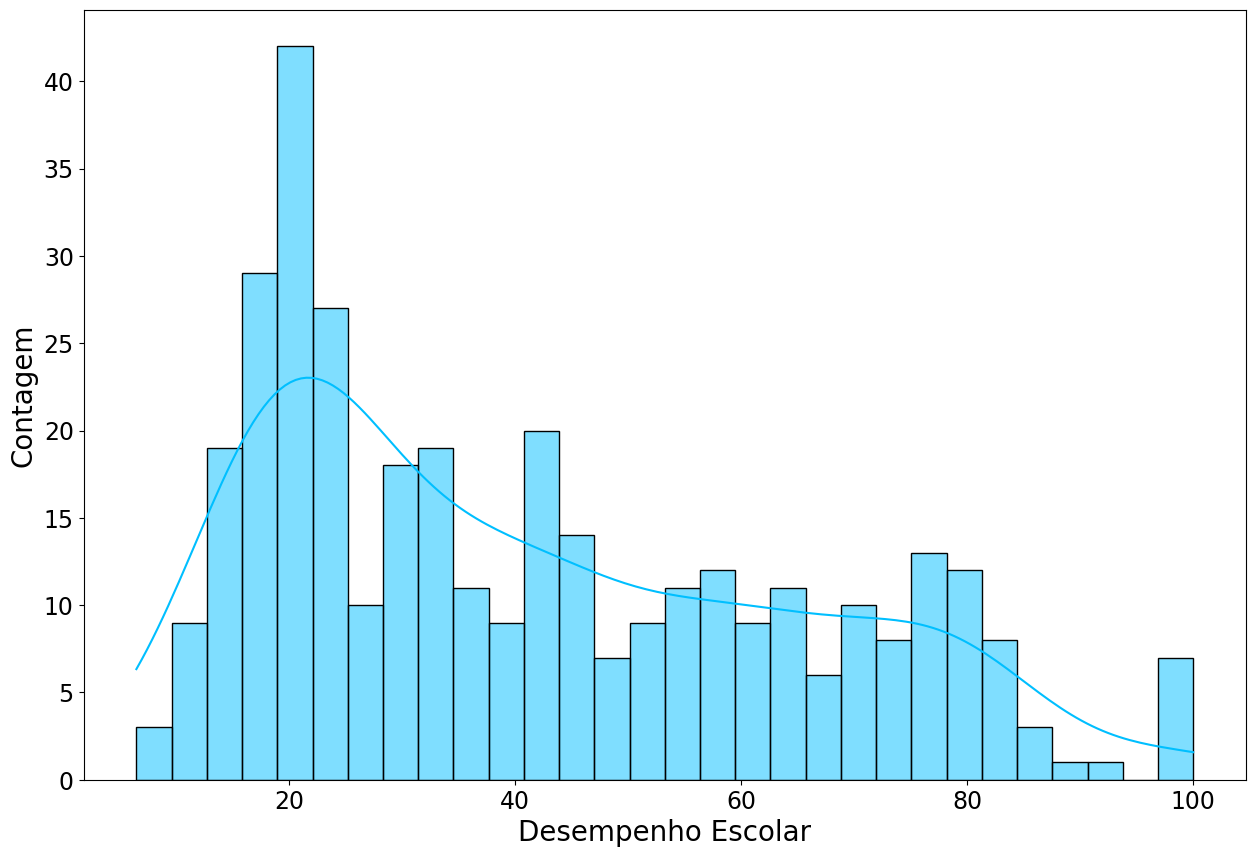

In [11]:
# In[1.5]: Kernel density estimation (KDE) - função densidade de probabilidade
#da variável dependente ('desempenho'), com histograma

plt.figure(figsize=(15,10))
sns.histplot(data=df_aluno_escola['desempenho'], kde=True,
             bins=30, color='deepskyblue')
plt.xlabel('Desempenho Escolar', fontsize=20)
plt.ylabel('Contagem', fontsize=20)
plt.tick_params(axis='y', labelsize=17)
plt.tick_params(axis='x', labelsize=17)
plt.show()

C:\Users\Lucas Rezende\AppData\Local\Temp\ipykernel_14132\3061153080.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_aluno_escola, x='escola', y='desempenho',
C:\Users\Lucas Rezende\AppData\Local\Temp\ipykernel_14132\3061153080.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df_aluno_escola, x='escola', y='desempenho',


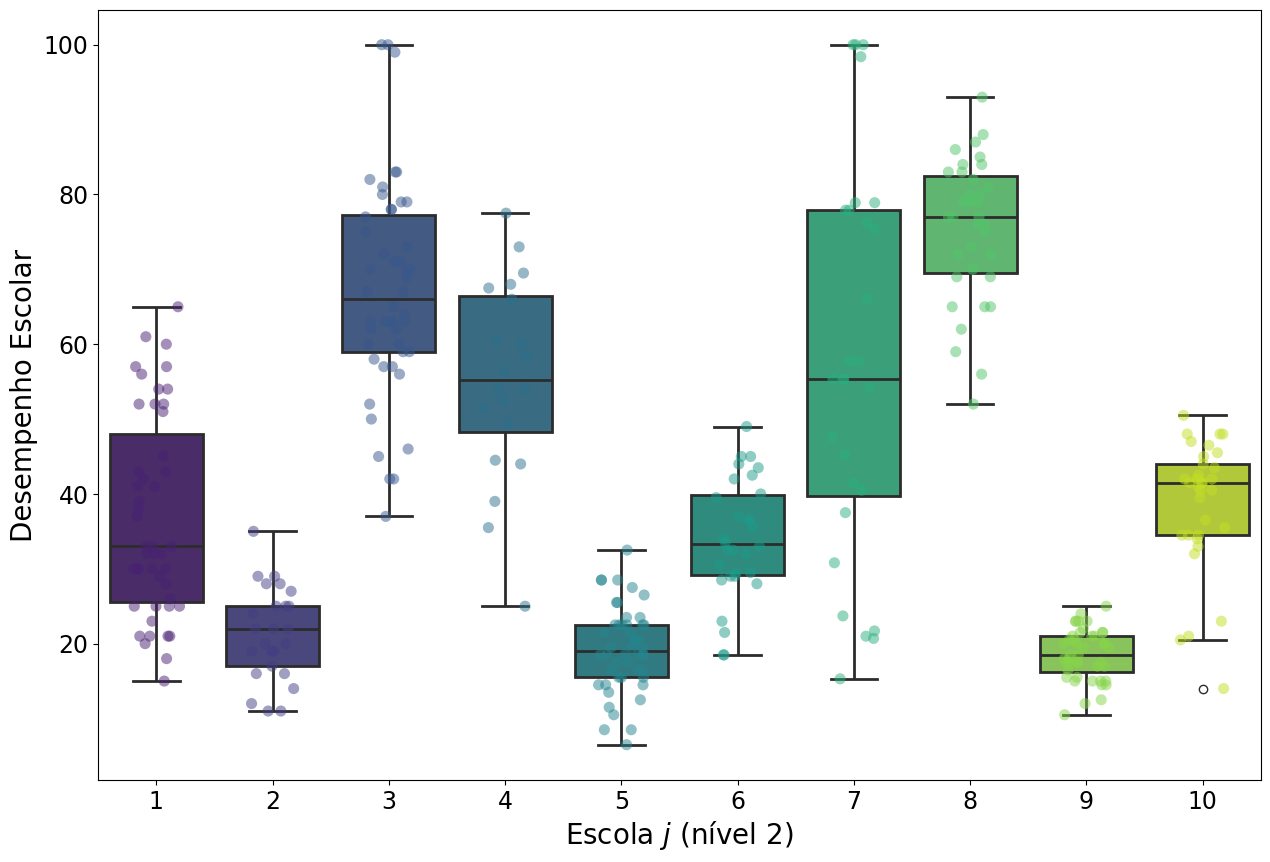

In [12]:
# In[1.6]: Boxplot da variável dependente ('desempenho') por escola

plt.figure(figsize=(15,10))
sns.boxplot(data=df_aluno_escola, x='escola', y='desempenho',
            linewidth=2, orient='v', palette='viridis')
sns.stripplot(data=df_aluno_escola, x='escola', y='desempenho',
              palette='viridis', jitter=0.2, size=8, alpha=0.5)
plt.ylabel('Desempenho Escolar', fontsize=20)
plt.xlabel('Escola $j$ (nível 2)', fontsize=20)
plt.tick_params(axis='y', labelsize=17)
plt.tick_params(axis='x', labelsize=17)
plt.show()

<Figure size 1500x1000 with 0 Axes>

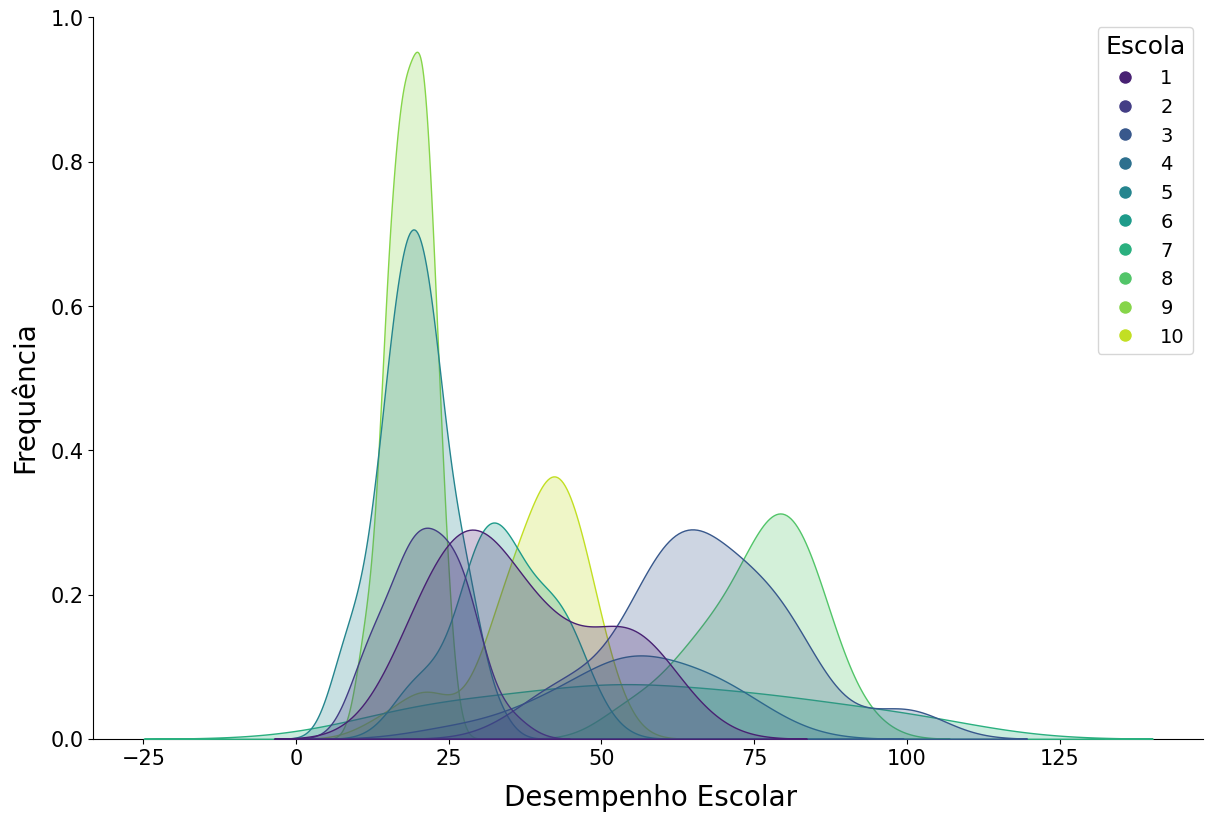

In [13]:
# In[1.7]: Kernel density estimation (KDE) - função densidade de probabilidade
#da variável dependente ('desempenho') por escola

escolas = df_aluno_escola['escola'].unique()
colors = sns.color_palette('viridis', len(escolas))

plt.figure(figsize=(15, 10))
g = sns.pairplot(df_aluno_escola[['escola', 'desempenho']], hue='escola',
                 height=8,
                 aspect=1.5, palette=colors)
g._legend.remove()
g.set(xlabel=None)
g.set(ylabel=None)
g.tick_params(axis='both', which='major', labelsize=15)

# Gera a legenda com cores e rótulos das escolas
legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=color,
                              markersize=10, label=escola)
                   for escola, color in zip(escolas, colors)]
plt.legend(handles=legend_elements, title='Escola', fontsize=14,
           title_fontsize=18)

# Adiciona os rótulos diretamente na figura
plt.gcf().text(0.5, -0.01, 'Desempenho Escolar', ha='center', fontsize=20)
plt.gcf().text(-0.01, 0.5, 'Frequência', va='center', rotation='vertical',
               fontsize=20)
plt.show()

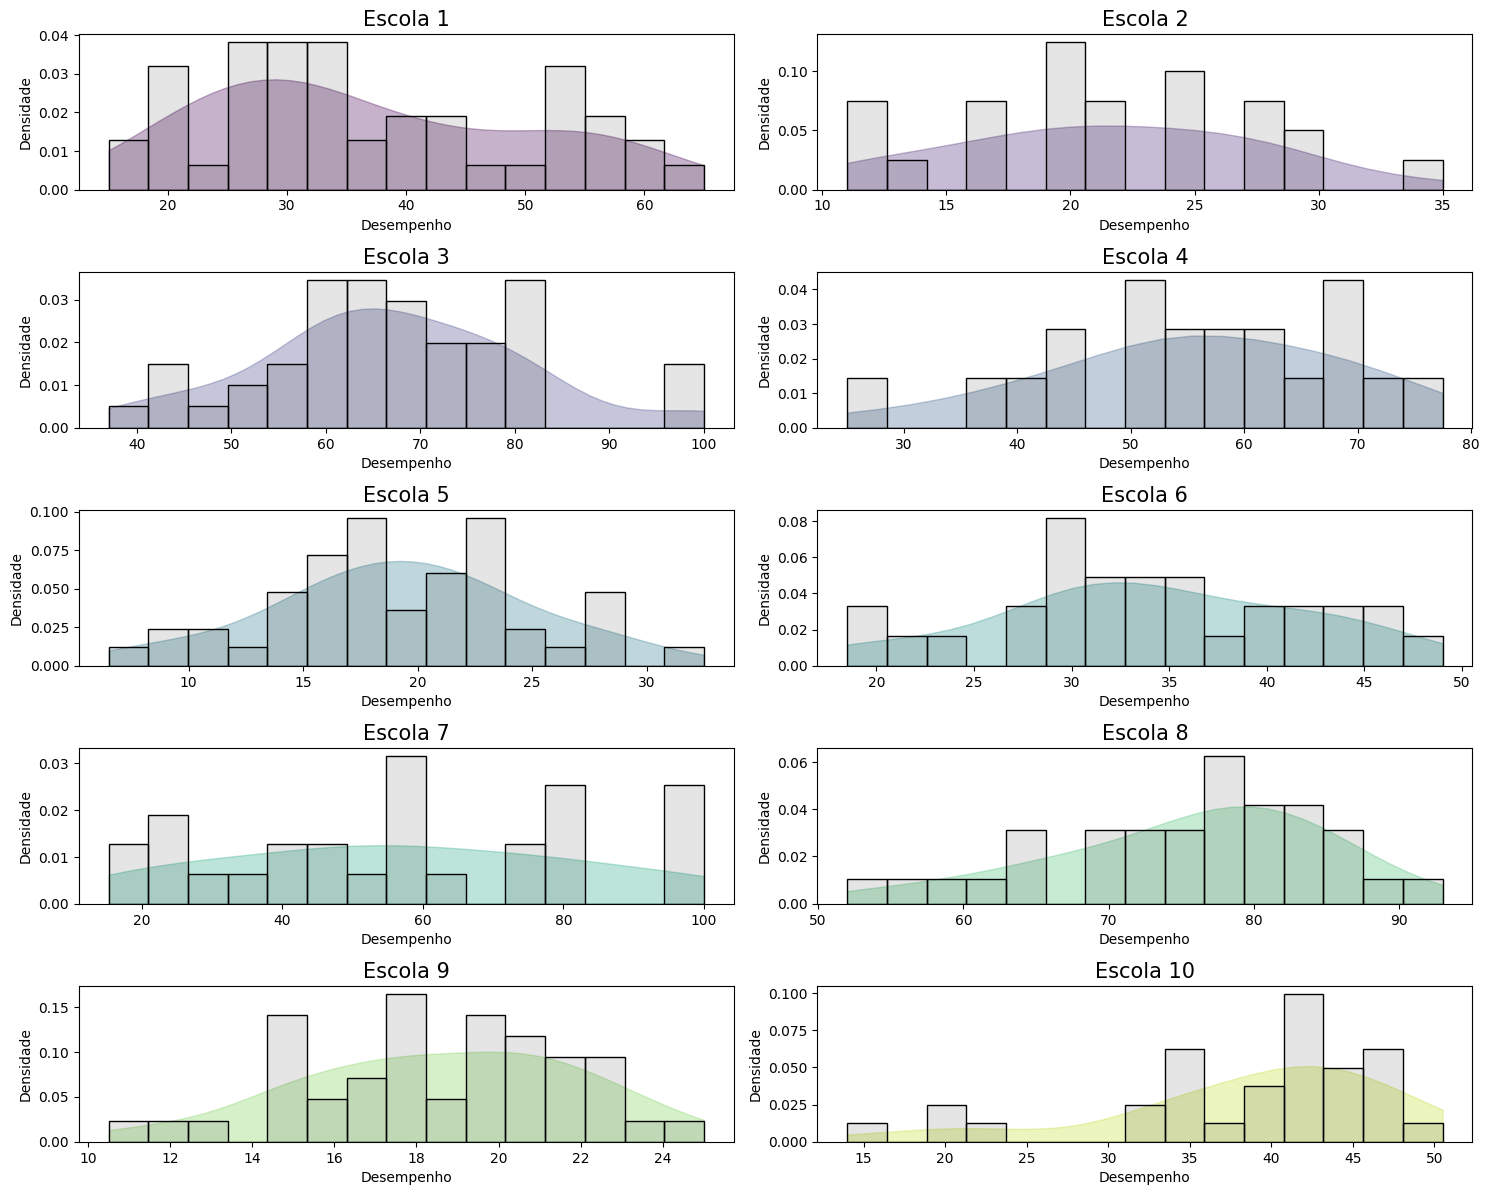

In [14]:
# In[1.8]: Kernel density estimation (KDE) - função densidade de probabilidade
#da variável dependente ('desempenho'), com histograma e por escola separadamente
#(função 'GridSpec' do pacote 'matplotlib.gridspec')

escolas = df_aluno_escola['escola'].unique()

fig = plt.figure(figsize=(15, 14))
gs = GridSpec(len(escolas) // 2 + 1, 2, figure=fig)

for i, escola in enumerate(escolas):
    ax = fig.add_subplot(gs[i])

    # Subset dos dados por escola
    df_escola = df_aluno_escola[df_aluno_escola['escola'] == escola]

    # Densidade dos dados
    densidade = gaussian_kde(df_escola['desempenho'])
    x_vals = np.linspace(min(df_escola['desempenho']),
                         max(df_escola['desempenho']), len(df_escola))
    y_vals = densidade(x_vals)

    # Plotagem da density area
    ax.fill_between(x_vals, y_vals,
                    color=sns.color_palette('viridis',
                                            as_cmap=True)(i/len(escolas)),
                    alpha=0.3)
    
    # Adiciona o histograma
    sns.histplot(df_escola['desempenho'], ax=ax, stat="density", color="black",
                 edgecolor="black", fill=True, 
                 bins=15, alpha=0.1)
    ax.set_title(f'Escola {escola}', fontsize=15)
    ax.set_ylabel('Densidade')
    ax.set_xlabel('Desempenho')

plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

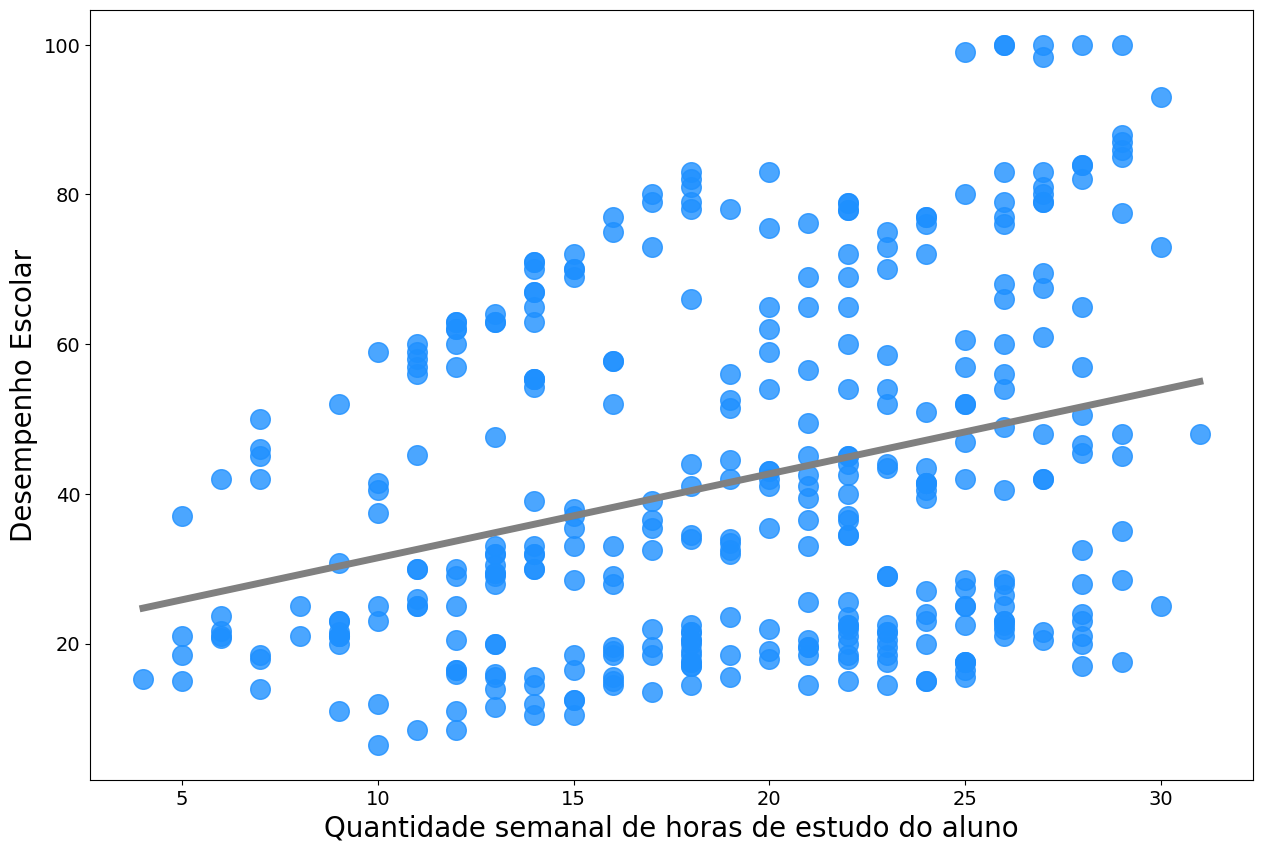

In [15]:
# In[1.9]: Gráfico de desempenho x horas (OLS)

plt.figure(figsize=(15,10))
sns.regplot(data=df_aluno_escola, x='horas', y='desempenho', marker='o', ci=False,
            scatter_kws={"color":'dodgerblue', 'alpha':0.8, 's':200},
            line_kws={"color":'grey', 'linewidth': 5})
plt.xlabel('Quantidade semanal de horas de estudo do aluno', fontsize=20)
plt.ylabel('Desempenho Escolar', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show


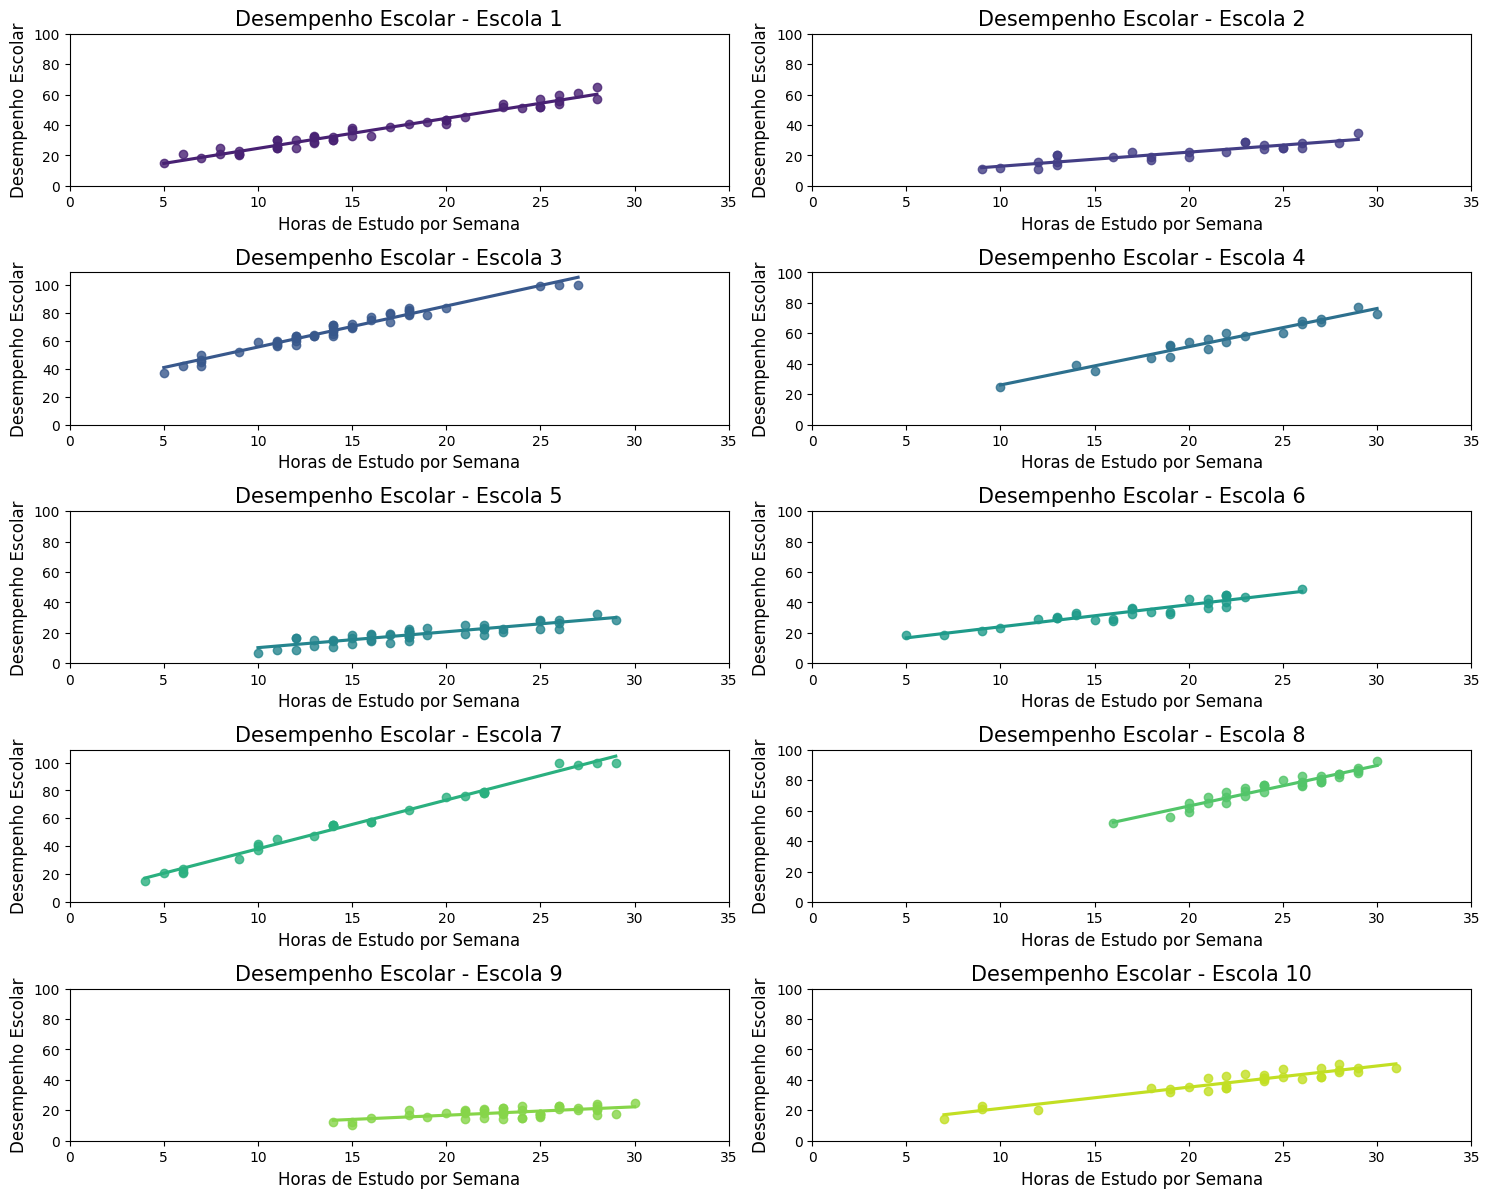

In [16]:
# In[1.10]: Gráfico de desempenho x horas (OLS) por escola separadamente
# Animação no ambiente Plots


# Obtenção da lista de escolas
escolas = df_aluno_escola['escola'].unique()

# Definição do número de cores na paleta viridis
num_cores = len(escolas)

# Criação do dicionário de mapeamento da escola -> cor
cor_escola = dict(zip(escolas, sns.color_palette('viridis', num_cores)))

# Configura a figura e o GridSpec para múltiplos subplots
fig = plt.figure(figsize=(15, 14))
gs = GridSpec(len(escolas) // 2 + 1, 2, figure=fig)

# Loop para cada escola
for idx, escola in enumerate(escolas):
    ax = fig.add_subplot(gs[idx])

    # Filtro dos dados para determinada escola
    data = df_aluno_escola[df_aluno_escola['escola'] == escola]

    # Criação do scatterplot e regressão linear usando regplot
    sns.regplot(x='horas', y='desempenho', data=data, ax=ax, ci=False, color=cor_escola[escola])

    # Customizações
    ax.set_title(f"Desempenho Escolar - Escola {escola}", fontsize=15)
    ax.set_xlabel("Horas de Estudo por Semana", fontsize=12)
    ax.set_ylabel("Desempenho Escolar", fontsize=12)
    ax.set_yticks(np.arange(0, 101, 20))
    ax.set_xticks(np.arange(0, 36, 5))

# Ajustar o layout dos subplots
plt.tight_layout()
plt.show()

Gerando gráficos:   0%|                                                                     | 0/10 [00:00<?, ?escola/s]C:\Users\Lucas Rezende\AppData\Local\Temp\ipykernel_14132\1430995285.py:34: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(plt_canvas.tostring_rgb(), dtype='uint8')
Gerando gráficos:  10%|██████                                                       | 1/10 [00:00<00:05,  1.71escola/s]C:\Users\Lucas Rezende\AppData\Local\Temp\ipykernel_14132\1430995285.py:34: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(plt_canvas.tostring_rgb(), dtype='uint8')
Gerando gráficos:  20%|████████████▏                                                | 2/10 [00:01<00:04,  1.63escola/s]C:\Users\Lucas Rezende\AppData\Local\Temp\ipykernel_14132\1430995285.py:3

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

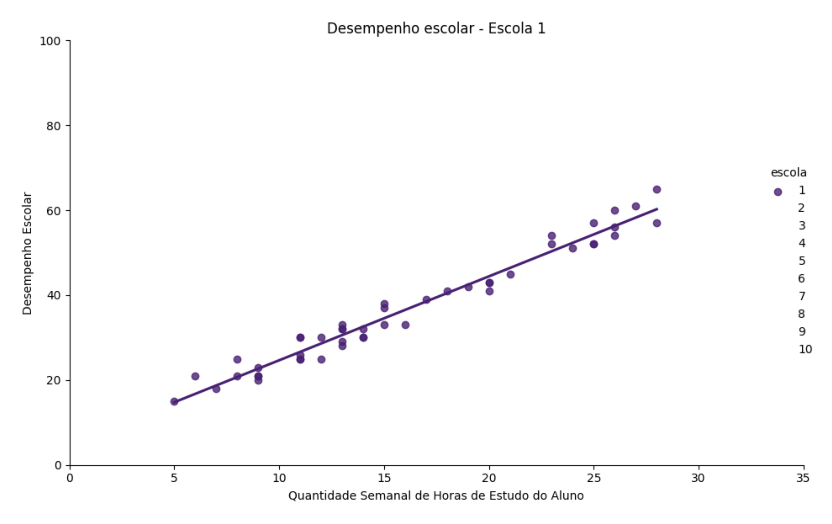

In [18]:
# In[1.11]: Gráfico de desempenho x horas (OLS) por escola separadamente
# Geração de uma Figura GIF

# Obtenção da lista de escolas
escolas = df_aluno_escola['escola'].unique()

# Definição do número de cores na paleta viridis
num_cores = len(escolas)

# Criação do dicionário de mapeamento da escola -> cor
cor_escola = dict(zip(escolas, sns.color_palette('viridis', num_cores)))

# Lista para armazenar os frames dos gráficos
frames = []

# Loop para cada escola com 'tqdm' para mostrar o progresso
for escola in tqdm(escolas, desc="Gerando gráficos", unit="escola"):
    # Filtro dos dados para determinada escola
    data = df_aluno_escola[df_aluno_escola['escola'] == escola]

    # Criação do lmplot com a cor específica
    sns.lmplot(x='horas', y='desempenho', data=data, hue='escola',
               height=6, aspect=1.5, ci=False, palette=[cor_escola[escola]])
    plt.title(f"Desempenho escolar - Escola {escola}")
    plt.xlabel("Quantidade Semanal de Horas de Estudo do Aluno")
    plt.ylabel("Desempenho Escolar")
    plt.yticks(np.arange(0, 101, 20))
    plt.xticks(np.arange(0, 36, 5))
    plt.tight_layout()
    
    # Converte o gráfico em um array de imagens
    plt_canvas = plt.get_current_fig_manager().canvas
    plt_canvas.draw()
    image = np.frombuffer(plt_canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(plt_canvas.get_width_height()[::-1] + (3,))

    # Anexa o array de imagens à lista de quadros (frames)
    frames.append(image)

    # Limpa o gráfico para a próxima iteração
    plt.clf()

# Salva os quadros (frames) como um GIF
imageio.mimsave('graficos_escolas.gif', frames, fps=1)

# Mostra o GIF
plt.imshow(frames[0])
plt.axis('off')
plt.show()

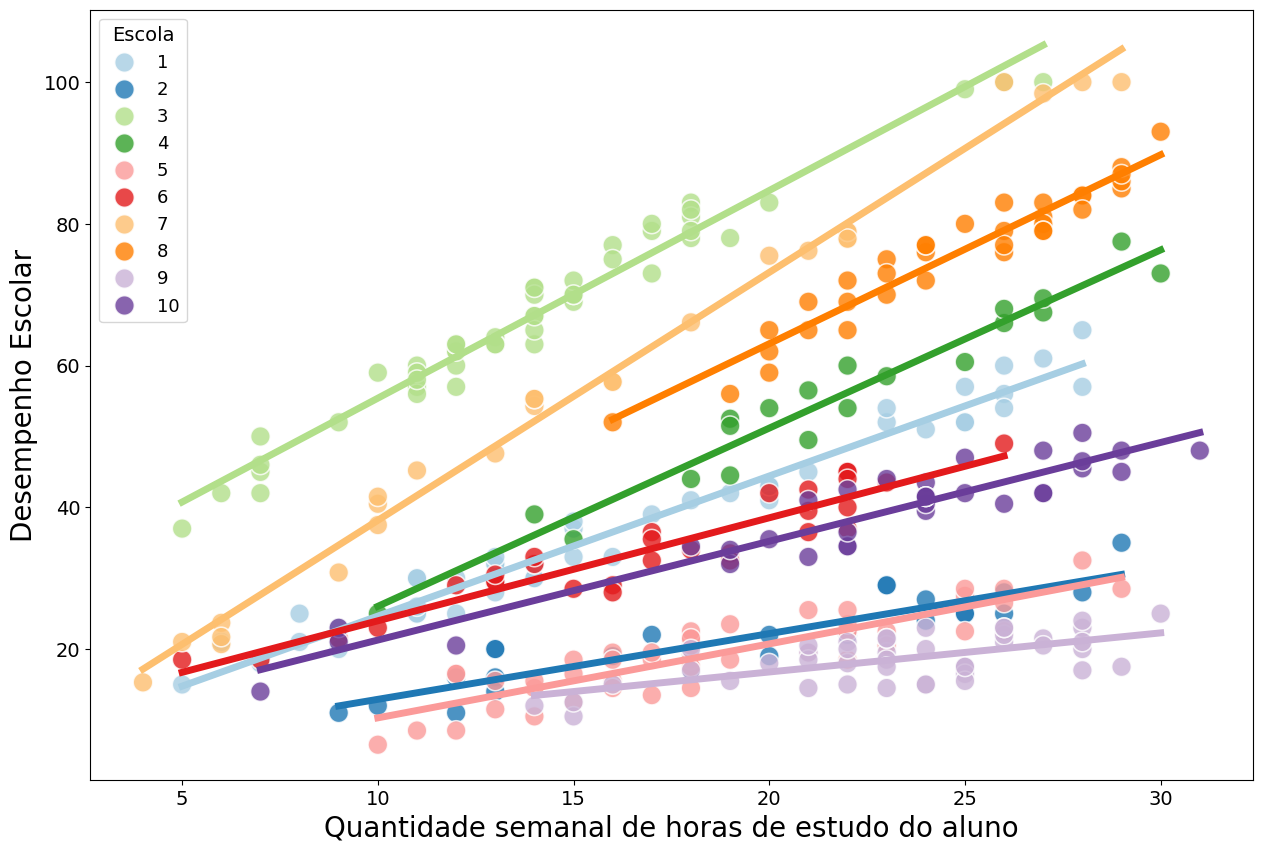

In [21]:
# In[1.12]: Gráfico de desempenho escolar em função da variável 'horas'
# Variação entre estudantes de uma mesma escola e entre escolas diferentes
# Visualização do contexto!
# NOTE QUE A PERSPECTIVA MULTINÍVEL NATURALMENTE CONSIDERA O COMPORTAMENTO
#HETEROCEDÁSTICO NOS DADOS!

palette = sns.color_palette('Paired',
                            len(df_aluno_escola['escola'].unique()))

plt.figure(figsize=(15,10))
sns.scatterplot(data=df_aluno_escola, x='horas', y='desempenho', hue='escola',
                palette=palette, s=200, alpha=0.8, edgecolor='w')

for escola in df_aluno_escola['escola'].cat.categories:
    subset = df_aluno_escola[df_aluno_escola['escola'] == escola]
    sns.regplot(data=subset, x='horas', y='desempenho', scatter=False, ci=False,
                line_kws={"color": palette[df_aluno_escola['escola'].cat.categories.get_loc(escola)], 'linewidth': 5})

plt.xlabel('Quantidade semanal de horas de estudo do aluno', fontsize=20)
plt.ylabel('Desempenho Escolar', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Escola', title_fontsize='14', fontsize='13', loc='upper left')
plt.show()

### Conclusões preliminares

- Há heterocedasticidade nos dados
- Há diferença nos interceptos e nas inclinações dos ajustes dependendo da escola


## Estimação do modelo nulo

O modelo nulo tem serventia para verificar se o modelo multinível é adequado.

In [23]:
# In[1.13]:
##############################################################################
#                        ESTIMAÇÃO DO MODELO NULO HLM2                       #
##############################################################################

# Estimação do modelo nulo (função 'MixedLM' do pacote 'statsmodels')

modelo_nulo_hlm2 = sm.MixedLM.from_formula(formula='desempenho ~ 1',
                                           groups='escola',
                                           re_formula='1',
                                           data=df_aluno_escola).fit()

# Parâmetros do 'modelo_nulo_hlm2'
modelo_nulo_hlm2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: desempenho
No. Observations: 358     Method:             REML      
No. Groups:       10      Scale:              142.9242  
Min. group size:  20      Log-Likelihood:     -1416.0074
Max. group size:  48      Converged:          Yes       
Mean group size:  35.8                                  
--------------------------------------------------------
               Coef.  Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      42.387    6.468 6.553 0.000 29.709 55.065
escola Var    414.067   16.695                          
========================================================

"""

### Entendendo o output

`Scale` = $Var(\epsilon_{ij})$\
`Intercept`= $\gamma_{00}$ Componente de efeito fixo\
`escola Var` = $Var(\nu_{0j})$

No modelo nulo, o desempenho é dado por:

\begin{equation}
\text{desempenho}_{ij} = \gamma_{00} + \nu_{0j} + \epsilon_{ij}
\end{equation}

\begin{equation}
ICC = \dfrac{Var(\nu_{0j})}{Var(\nu_{0j}) + Var(\epsilon_{ij}) }
\end{equation}

In [ ]:
Nesse caso temos:

In [28]:
ICC = 414.067 / (414.067 + 142.9242)
ICC

0.7433995366533618

Ou seja, 74% da variância dos dados é devida ao efeito escola.

### Análise da significância estatística dos efeitos aleatórios

In [29]:
# In[1.14]: Análise da significância estatística dos efeitos aleatórios de
#intercepto

teste = float(modelo_nulo_hlm2.cov_re.iloc[0, 0]) /\
    float(pd.DataFrame(modelo_nulo_hlm2.summary().tables[1]).iloc[1, 1])

p_value = 2 * (1 - stats.norm.cdf(abs(teste)))

print(f"Estatística z para a Significância dos Efeitos Aleatórios: {teste:.3f}")
print(f"P-valor: {p_value:.3f}")

if p_value >= 0.05:
    print("Ausência de significância estatística dos efeitos aleatórios ao nível de confiança de 95%.")
else:
    print("Efeitos aleatórios contextuais significantes ao nível de confiança de 95%.")

Estatística z para a Significância dos Efeitos Aleatórios: 24.802
P-valor: 0.000
Efeitos aleatórios contextuais significantes ao nível de confiança de 95%.


## Comparação do modelo nulo - Modelagem OLS x Multinível

In [30]:
# In[1.15]:
##############################################################################
#                   COMPARAÇÃO DO HLM2 NULO COM UM OLS NULO                  #
##############################################################################

# Estimação de um modelo OLS nulo

modelo_ols_nulo = sm.OLS.from_formula(formula='desempenho ~ 1',
                                      data=df_aluno_escola).fit()

# Parâmetros do 'modelo_ols_nulo'
modelo_ols_nulo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                sáb, 05 out 2024   Prob (F-statistic):                nan
Time:                        11:46:09   Log-Likelihood:                -1633.5
No. Observations:                 358   AIC:                             3269.
Df Residuals:                     357   BIC:                             3273.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     41.5542      1.228     33.852      0.000      39.140      43.968
==============================================================================
Omnibus:                       38.443   Durbin-Watson:                   0.584
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.903
Skew:                           0.626   Prob(JB):                     1.95e-07
Kurtosis:                       2.291   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

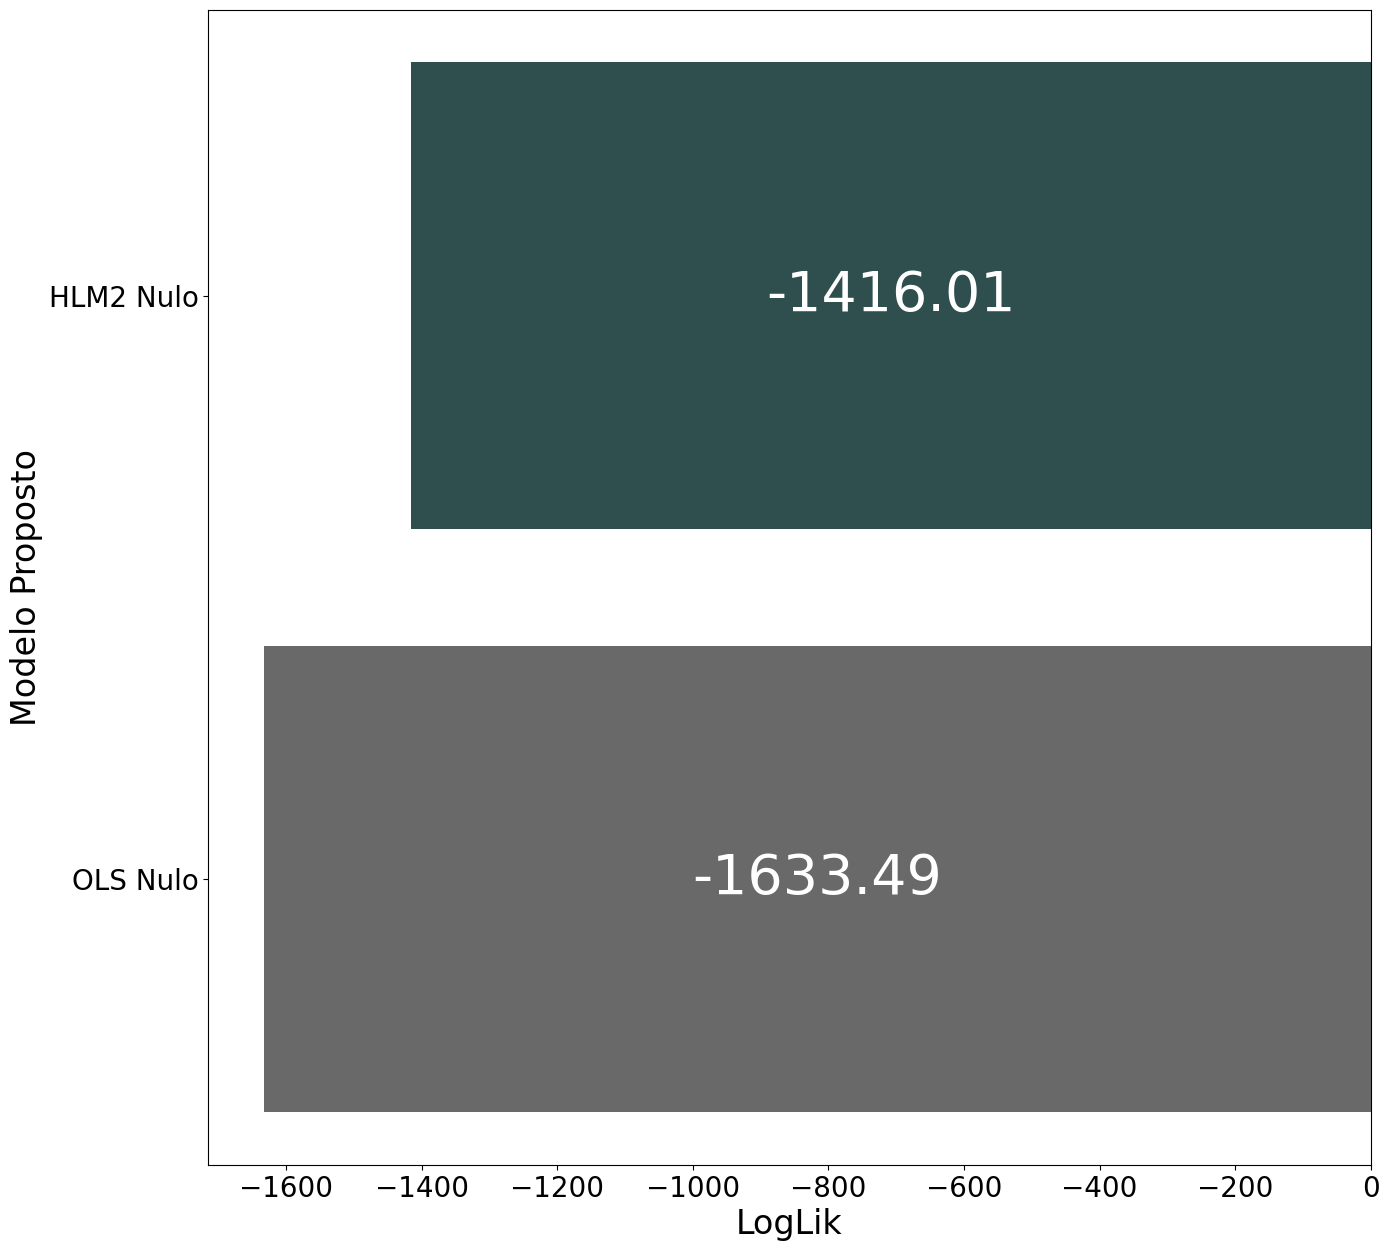

In [31]:
# In[1.16]: Gráfico para comparação visual dos logLiks dos modelos estimados
#até o momento

df_llf = pd.DataFrame({'modelo':['OLS Nulo','HLM2 Nulo'],
                      'loglik':[modelo_ols_nulo.llf,modelo_nulo_hlm2.llf]})

fig, ax = plt.subplots(figsize=(15,15))

c = ['dimgray','darkslategray']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=40)
ax.set_ylabel("Modelo Proposto", fontsize=24)
ax.set_xlabel("LogLik", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
plt.show()

In [33]:
# In[1.17]: Teste de razão de verossimilhança entre o 'modelo_nulo_hlm2' e o
#'modelo_ols_nulo'

def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llf
    llk_2 = modelo_1.llf
    
    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1) # 1 grau de liberdade
    
    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

# In[1.18]: Teste de de razão de verossimilhança para comparar as estimações
#dos 'modelo_ols_nulo' e 'modelo_nulo_hlm2'

lrtest([modelo_ols_nulo, modelo_nulo_hlm2])

Likelihood Ratio Test:
-2.(LL0-LLm): 434.96
p-value: 0.000

==================Result======================== 

H1: Different models, favoring the one with the highest Log-Likelihood


# Anotações

## Vantagens dos modelos multinível

O processo multinível consegue captar as particularidades de cada subgrupo do conjunto de dados, e por isso é mais eficaz que métodos que utilizam Mínimos Quadrados Ordinários (MQO ou OLS).

O processo de dummyzação com o procedimento hot encoding, só garante variância nos efeitos de intercepto. Ele só gera retas paralelas no ajuste linear, não tem capacidade de gerar inclinações diferentes.

Os modelos GLM são um caso particular dos modelos multinível.

---

## Paradoxo de simpson

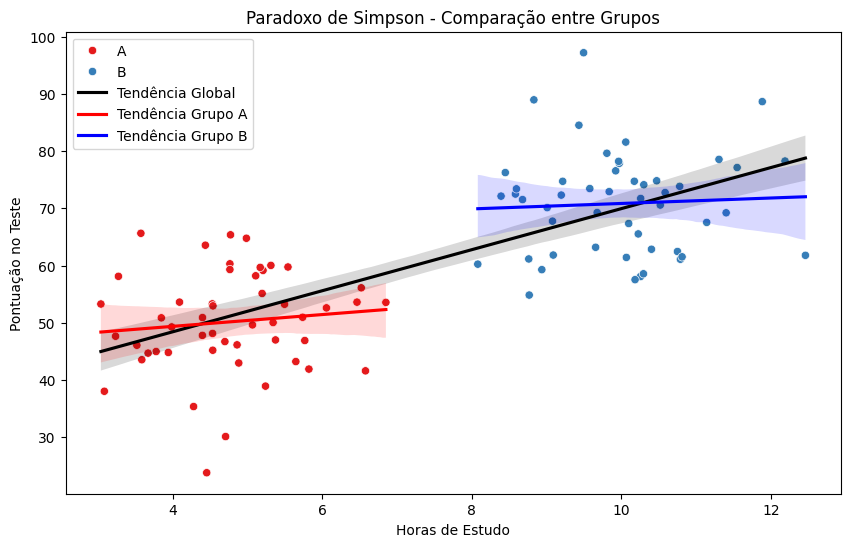

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Criar um conjunto de dados fictício com dois grupos, A e B
np.random.seed(42)
n = 100
group_A = pd.DataFrame({
    'Horas de Estudo': np.random.normal(5, 1, n//2),  # Grupo A: Menos horas de estudo
    'Pontuação no Teste': np.random.normal(50, 10, n//2),  # Grupo A: Menor pontuação
    'Grupo': ['A']*(n//2)
})

group_B = pd.DataFrame({
    'Horas de Estudo': np.random.normal(10, 1, n//2),  # Grupo B: Mais horas de estudo
    'Pontuação no Teste': np.random.normal(70, 10, n//2),  # Grupo B: Maior pontuação
    'Grupo': ['B']*(n//2)
})

# Combinar os dois grupos em um único DataFrame
dados = pd.concat([group_A, group_B])

# Criar um gráfico para cada grupo com cores diferentes
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Horas de Estudo', y='Pontuação no Teste', hue='Grupo', data=dados, palette='Set1')

# Adicionar uma linha de regressão para ilustrar a tendência geral (sem segmentação)
sns.regplot(x='Horas de Estudo', y='Pontuação no Teste', data=dados, scatter=False, color='black', label='Tendência Global')

# Adicionar linhas de regressão para cada grupo separadamente
sns.regplot(x='Horas de Estudo', y='Pontuação no Teste', data=group_A, scatter=False, color='red', label='Tendência Grupo A')
sns.regplot(x='Horas de Estudo', y='Pontuação no Teste', data=group_B, scatter=False, color='blue', label='Tendência Grupo B')

# Configurações do gráfico
plt.title('Paradoxo de Simpson - Comparação entre Grupos')
plt.legend()
plt.show()


---

## O que são modelos multiníveis?

**Modelos multinível** (ou **modelos hierárquicos**, **modelos de efeitos mistos**) são uma classe de modelos estatísticos projetados para analisar dados com **estrutura hierárquica** ou **agrupada**, onde as observações não são independentes entre si. Esses modelos são amplamente utilizados quando os dados apresentam diferentes níveis de agrupamento, como estudantes em escolas, pacientes em hospitais ou medidas repetidas em indivíduos ao longo do tempo.

Por que usar modelos multinível?

Em muitas situações, as observações dentro de um grupo (como uma escola ou um hospital) são mais semelhantes entre si do que em relação às observações de outros grupos. Isso gera dependências nos dados, o que viola a suposição de independência dos erros em modelos tradicionais de regressão. Modelos multinível tratam dessas dependências ao incluir **efeitos aleatórios** que permitem que os coeficientes do modelo variem entre os grupos.

Estrutura dos Modelos Multinível

Um modelo multinível inclui:
- **Nível 1 (nível mais baixo)**: Representa as observações individuais dentro de um grupo, como alunos em uma escola ou medições repetidas em um indivíduo.
- **Nível 2 (nível de agrupamento)**: Representa os grupos ou clusters, como diferentes escolas, hospitais ou indivíduos.

Exemplo:
Imagine que estamos estudando o desempenho de estudantes de várias escolas. Um modelo de regressão linear tradicional poderia ser:

$
\text{Score}_{ij} = \beta_0 + \beta_1 \text{Ability}_{ij} + \epsilon_{ij}
$

Onde:
- $ \text{Score}_{ij} $ é a pontuação do aluno $i$ na escola $j$.
- $ \text{Ability}_{ij} $ é a habilidade do aluno.
- $ \epsilon_{ij} $ é o erro aleatório.

Esse modelo assume que o intercepto $ \beta_0 $ e a inclinação $ \beta_1 $ são os mesmos para todas as escolas. No entanto, a realidade pode ser que cada escola tem um efeito diferente sobre o desempenho dos alunos. Para capturar essa variação entre escolas, usamos um modelo multinível:

$
\text{Score}_{ij} = (\beta_0 + u_{0j}) + \beta_1 \text{Ability}_{ij} + \epsilon_{ij}
$

Aqui, $ u_{0j} $ é o **efeito aleatório** associado à escola $ j $, permitindo que o intercepto varie de escola para escola.

Componentes dos Modelos Multinível:
1. **Efeitos fixos**: São os coeficientes que se aplicam a todas as unidades no conjunto de dados. Representam a relação média entre a variável independente e a variável dependente.
   
2. **Efeitos aleatórios**: São os coeficientes que podem variar entre os grupos (como escolas ou hospitais). Capturam a variação nos interceptos ou nas inclinações entre os diferentes grupos.

Exemplo de modelo com efeito aleatório no intercepto:
$
Y_{ij} = (\beta_0 + u_{0j}) + \beta_1 X_{ij} + \epsilon_{ij}
$

Onde:
- $ \beta_0 $ é o intercepto geral (efeito fixo).
- $ u_{0j} $ é o efeito aleatório que representa a variação no intercepto para cada grupo $j$.
- $ \beta_1 $ é a inclinação (efeito fixo) que se aplica a todas as observações.

Vantagens dos Modelos Multinível:

1. **Consideram a dependência entre observações**: Modelos multinível ajustam-se à estrutura hierárquica dos dados, permitindo uma modelagem mais realista.
   
2. **Modelam variações entre grupos**: Eles permitem que os interceptos ou inclinações variem entre grupos, capturando efeitos específicos de cada grupo (como o impacto de diferentes escolas sobre o desempenho dos alunos).
   
3. **Flexibilidade**: Modelos multinível podem incluir efeitos aleatórios e fixos ao mesmo tempo, fornecendo uma modelagem mais rica e adaptada aos dados.

4. **Reduzem vieses**: Em modelos tradicionais que ignoram a estrutura hierárquica, pode-se subestimar ou superestimar efeitos. Modelos multinível minimizam esse risco ao ajustar adequadamente a variabilidade entre grupos.

Exemplos de Aplicação:

1. **Educação**: Analisar o desempenho de alunos em diferentes escolas, ajustando para variações entre escolas.
   
2. **Medicina**: Estudar a resposta de pacientes ao tratamento, levando em consideração a variabilidade entre hospitais ou clínicas.

3. **Psicologia**: Analisar dados longitudinais (dados repetidos no tempo) de indivíduos, capturando variações entre indivíduos.

4. **Economia**: Estudar o crescimento econômico de diferentes países, permitindo que os efeitos dos fatores econômicos variem entre países.

Tipos de Modelos Multinível:
- **Modelos de intercepto aleatório**: Permitem que o intercepto varie entre os grupos.
- **Modelos de inclinação aleatória**: Permitem que a inclinação (coeficiente de uma variável explicativa) varie entre os grupos.
- **Modelos de efeitos mistos**: Combinação de intercepto e inclinação aleatórios.

Software para Modelos Multinível:
Modelos multinível podem ser implementados em várias plataformas estatísticas, incluindo **R** (pacotes como `lme4`), **Python** (usando `statsmodels` ou `PyMC3`), **Stata**, e **SAS**.

Resumo:
Modelos multinível são ferramentas poderosas para lidar com dados estruturados hierarquicamente. Eles permitem modelar as variações dentro e entre grupos de maneira eficiente, ajustando para a dependência das observações e oferecendo uma análise mais precisa e robusta do que modelos tradicionais de regressão.

---

Num processo de regressão linear, devemos escolher entre fazer o processo de dummyzação e a modelagem multinível.

---

## Clusterização e Modelagem Multinível

Podemos utilizar a técnica de clusterização para identificar contextos latentes (não diretamente observáveis) para definir níveis numa análise multinível.

---

## Aderência dos resíduos à normalidade

Mesmo que a transformação boxcox não garanta a aderência dos resíduos à normalidade, a modelagem multinível pode garantir.

---

Não há procedimento stepwize para modelagem multinível

---

In [ ]:
ICC (Interclass correlation)